In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
import zipfile
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
zf = zipfile.ZipFile('../data/test.csv.zip')
zf.extract('test.csv', path='../data')
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

## Exploratory data analysis

### Preliminary data exploration

The next cells provide some information about the data we are using in this project.

In [3]:
print('There are {a} data points and {b} features in the training data.'.format(a=tX.shape[0], b=tX.shape[1]))
miss_values_tr = len(tX[tX==-999])
miss_values_te = len(tX_test[tX_test==-999])
print('There are {a} missing values for a total number of {b} values in the training dataset. \n -> {c}% are missing values'.format(a=miss_values_tr, b=tX.shape[0]*tX.shape[1], c = 100*miss_values_tr/(tX.shape[0]*tX.shape[1])))
print('There are {a} missing values for a total number of {b} values in the test dataset. \n -> {c}% are missing values'.format(a=miss_values_te, b=tX_test.shape[0]*tX_test.shape[1], c = 100*miss_values_te/(tX_test.shape[0]*tX_test.shape[1])))

There are 250000 data points and 30 features in the training data.
There are 1580052 missing values for a total number of 7500000 values in the training dataset. 
 -> 21.06736% are missing values
There are 3588434 missing values for a total number of 17047140 values in the test dataset. 
 -> 21.050064702935508% are missing values


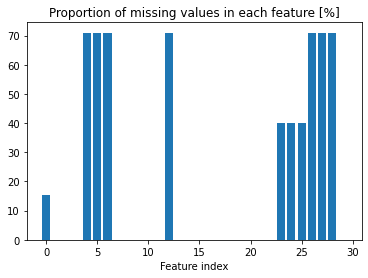

In [4]:
missing_proportions = []
for i in range(tX.shape[1]):
    prop = 100 * len(tX[tX[:,i]==-999]) / len(tX[:,i])
    missing_proportions.append(prop)

plt.bar(range(30), missing_proportions)
plt.title("Proportion of missing values in each feature [%]")
plt.xlabel("Feature index")
plt.show()

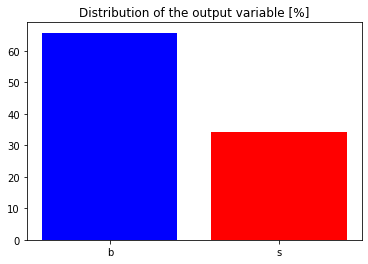

In [5]:
s = np.sum(y)
b = len(y) - s
tot = len(y)
labels =  [(b/tot)*100, (s/tot)*100]
plt.bar(['b', 's'], labels, color = ['b', 'r'])
plt.title("Distribution of the output variable [%]")
plt.show()

Preprocessing due to preliminary data analysis (non-relevant features removed after the whole data analysis.)

In [6]:
from data_processing import replace_miss

# Replace missing values of each feature by the feature mean 
tX = replace_miss(tX)
tX_test = replace_miss(tX_test)

### Univarate analysis

Statistical view of each feature using histograms/distributions and boxplots.

In [7]:
# Libraries used for visualization purpose
import pandas as pd
import seaborn as sns

In [8]:
#names = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",", names=True, dtype=str).dtype.names
names = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",", names=True, dtype=str).dtype.names
df_mean = pd.DataFrame(tX, columns = np.array(names[2:]))
df_mean['y'] = y

C:\Users\Simon\anaconda3\envs\CS433\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


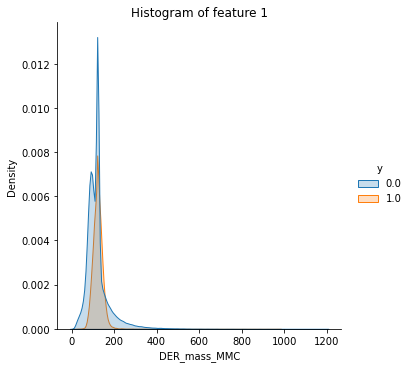

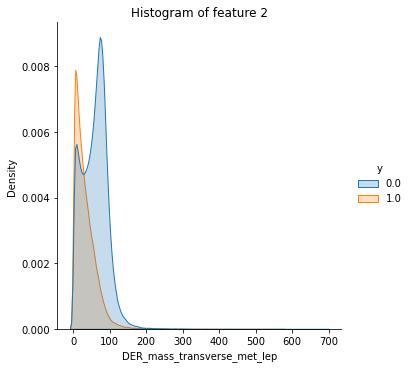

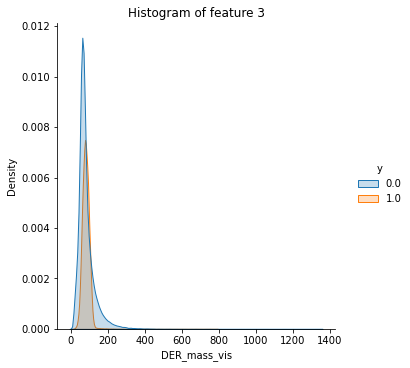

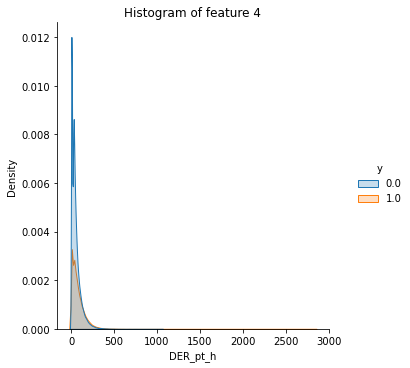

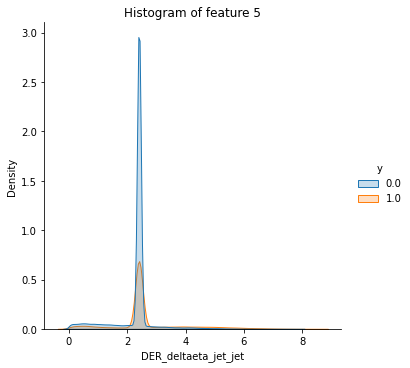

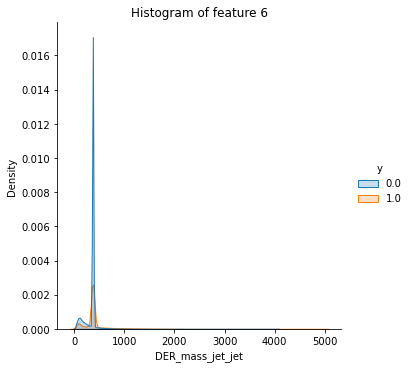

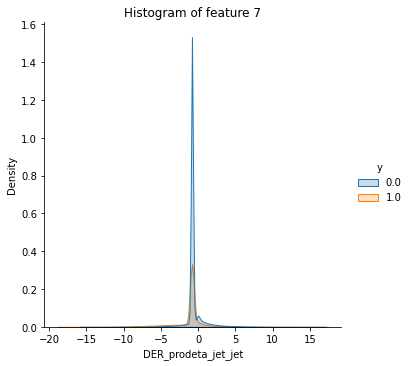

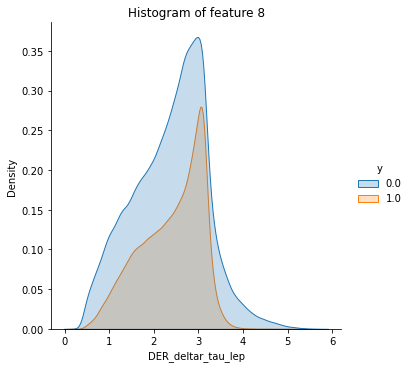

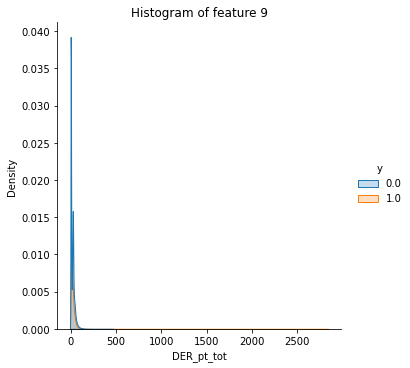

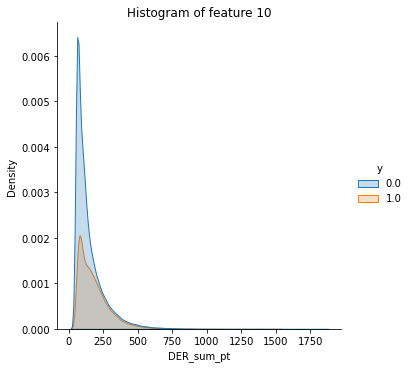

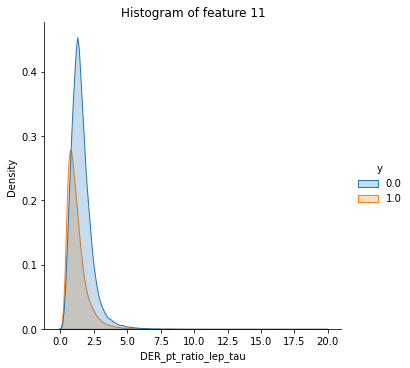

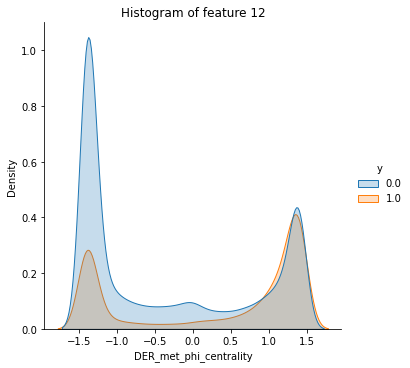

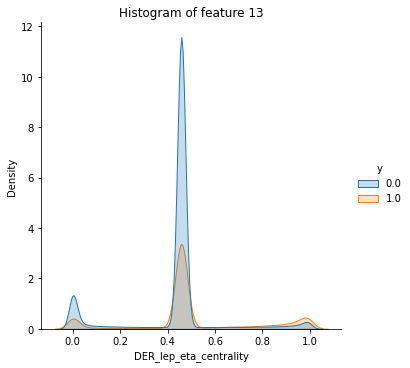

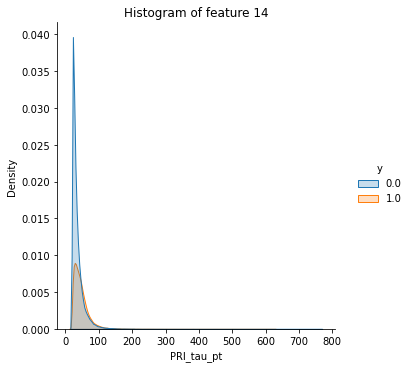

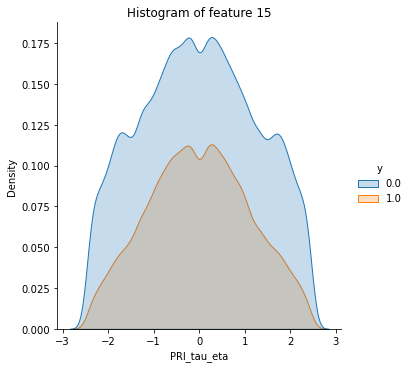

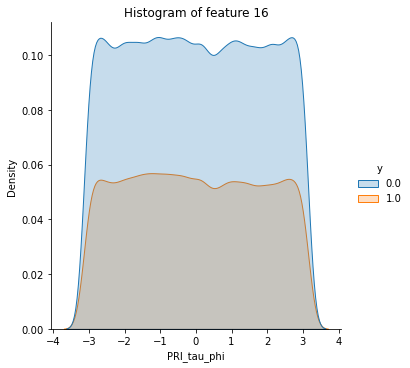

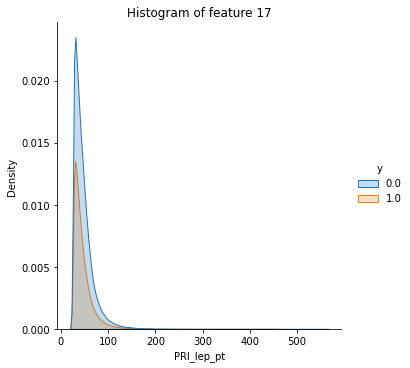

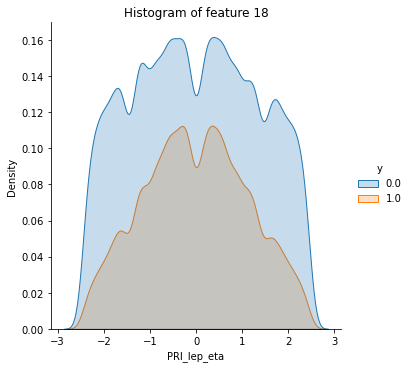

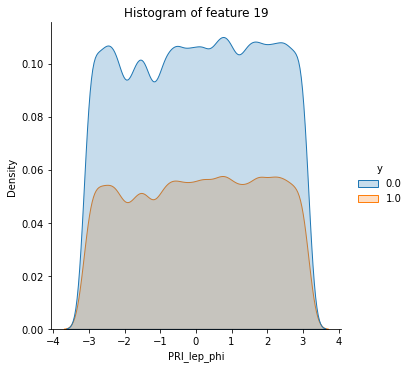

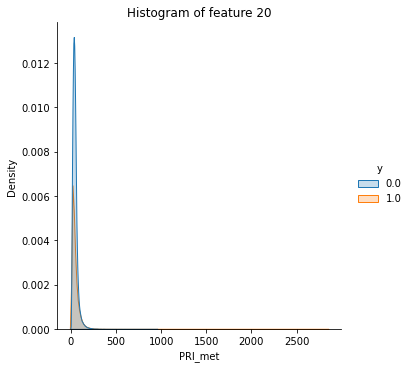

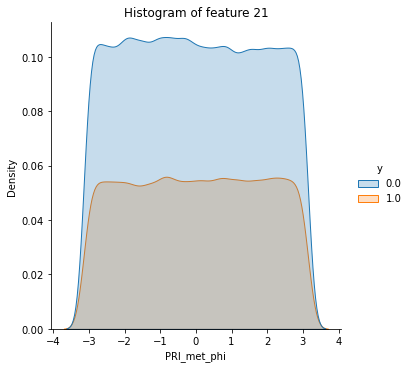

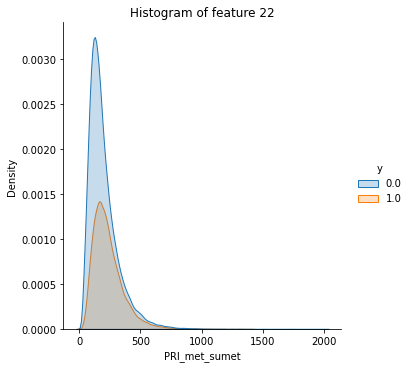

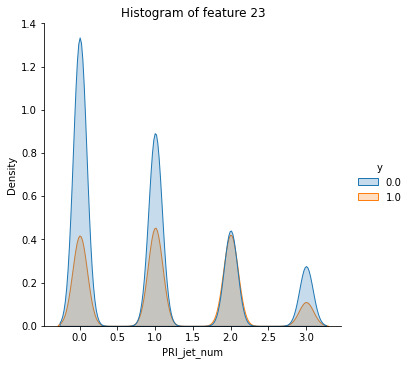

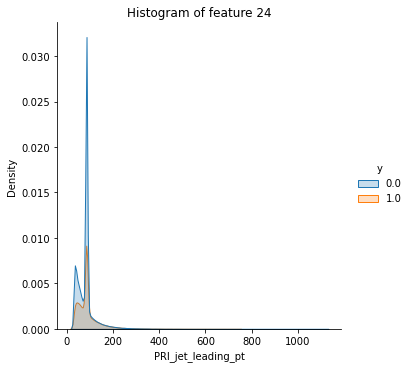

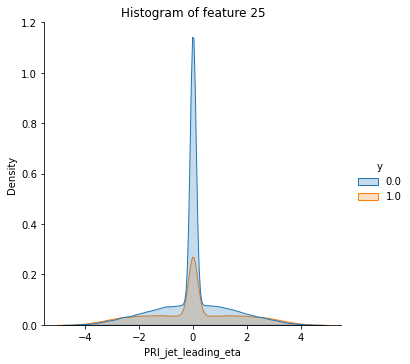

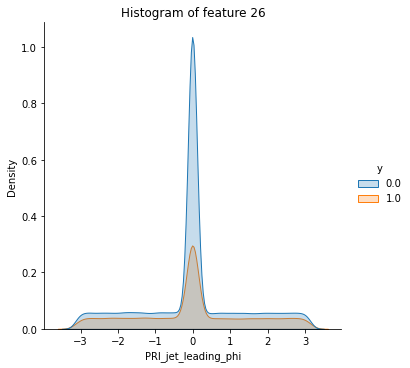

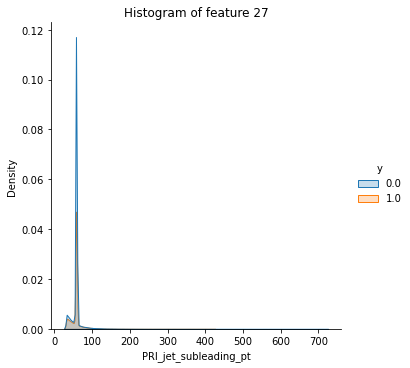

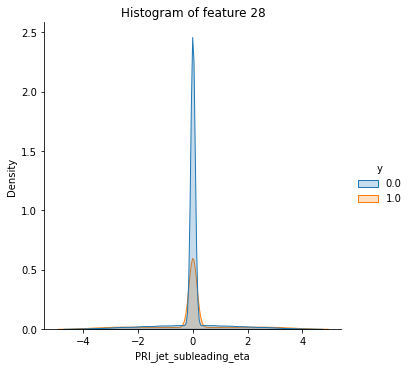

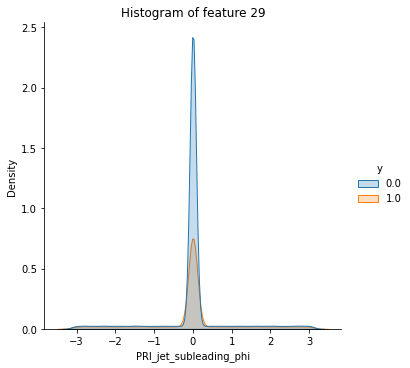

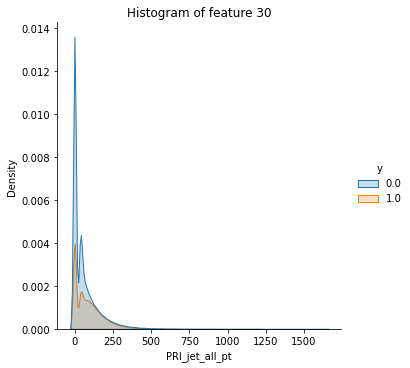

In [9]:
# Plot of the feature distributions
for i in range(len(names[2:])):
    sns.displot(df_mean, x=names[i+2], hue='y', kind="kde", fill=True)
    plt.title("Histogram of feature {nb}".format(nb=i+1))

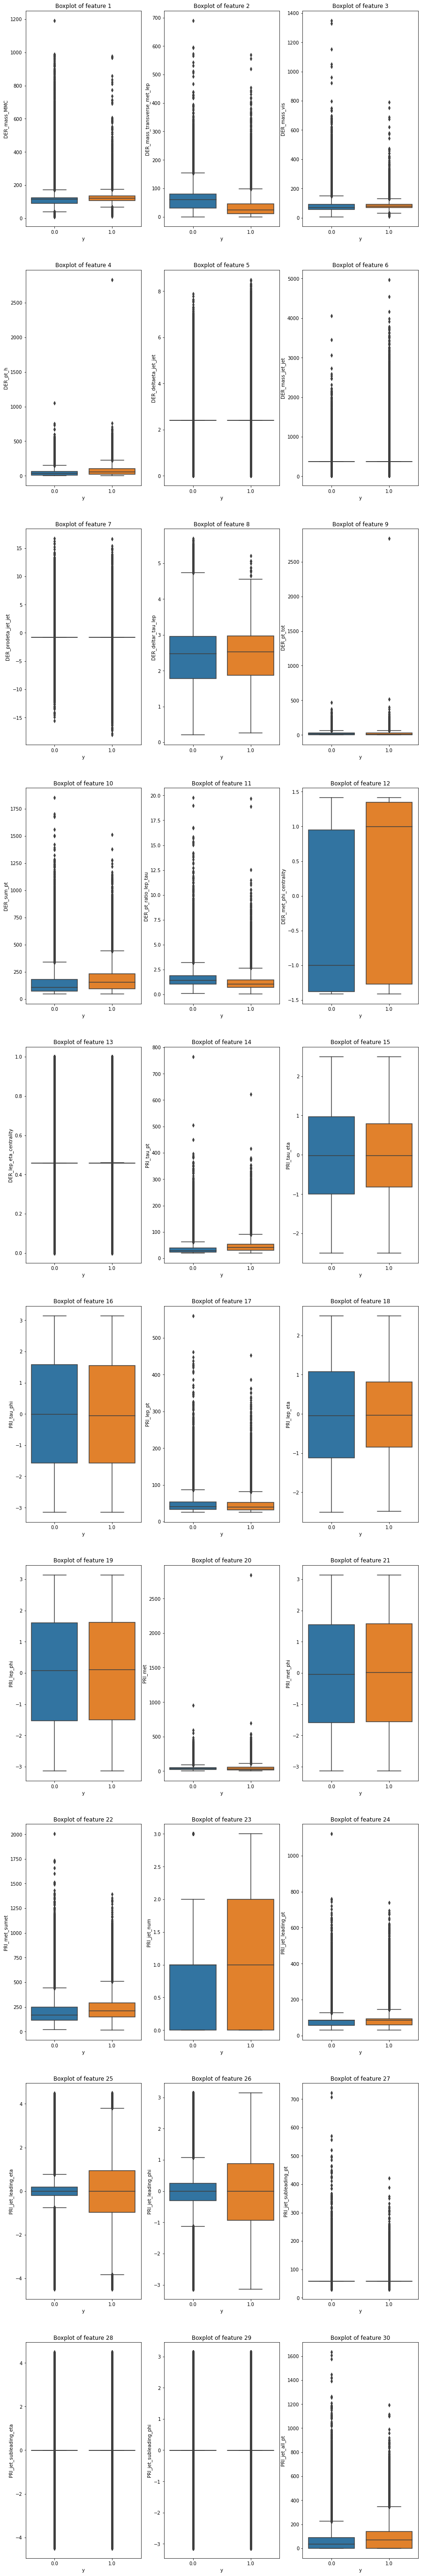

In [10]:
# Plot of the boxplots
col = np.ravel(np.indices((3, 10))[0].T)
row = np.ravel(np.indices((3, 10))[1].T)
fig, axs = plt.subplots(ncols=3, nrows=len(names[2:])//3, figsize=(15,100))
for i in range(len(names[2:])):
    sns.boxplot(x = 'y', y = names[i+2], data = df_mean, ax = axs[row[i],col[i]])
    axs[row[i],col[i]].set(title="Boxplot of feature {nb}".format(nb=i+1))

### Covariate analysis

Analysis of the correlation between the different features.

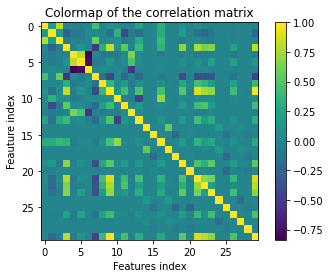

In [11]:
coeff_matrix = np.corrcoef(tX.T)
plt.imshow(coeff_matrix)
plt.xlabel("Features index")
plt.ylabel("Feauture index")
plt.colorbar()
plt.title("Colormap of the correlation matrix")
plt.show()

## Feature processing

Removal of all non-relevant features from dataset.

In [12]:
removed_indices_missing = [4, 5, 6, 12, 26, 27, 28]
removed_indices_univariate = [15, 18, 20, 25]
removed_indices_covariate = [9, 29]
removed_indices = removed_indices_univariate + removed_indices_covariate + removed_indices_missing
tX = np.delete(tX, removed_indices, 1)
tX_test = np.delete(tX_test, removed_indices, 1)

## Preprocessing

In [13]:
from data_processing import split_data, standardize, build_model_data
#train_tx, train_y, val_tx, val_y, test_tx, test_y = preprocessing(tX, y, tX_test, y_test)
train_x, train_y, val_x, val_y = split_data(tX, y, ratio=0.7, seed=1)

train_x, train_means, train_stds = standardize(train_x)
val_x = (val_x - train_means) / train_stds
test_x = (tX_test - train_means) / train_stds

train_y, train_tx = build_model_data(train_x, train_y)
val_y, val_tx = build_model_data(val_x, val_y)
test_y, test_tx = build_model_data(test_x, y_test)

## Cross-validation

Parameters definition for all the cross validations and spliting of the data in k (=?) folds

In [14]:
from cross_validation import*

seed = 1
k_fold = 5

max_iters = [50, 100, 150, 200]
max_iters_SGD = [50, 100, 150, 200, 500]
gammas = np.logspace(-4, 0, 30)
lambdas = np.logspace(-4, 0, 30)

# split data in k fold
k_indices = build_k_indices(train_y, k_fold, seed)

#### Gradient descent

In [27]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each lambda is lambdas
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_GD(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [28]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 0.4199134827417611. max_iter = 200, gamma = 0.38566204211634725. 
minimum test rmse: 0.41991229971596616. max_iter = 200, gamma = 0.38566204211634725. 
maximum train accuracy: 0.7337085714285715. max_iter = 150, gamma = 0.2807216203941176. 
maximum test accuracy: 0.7337085714285715. max_iter = 200, gamma = 0.20433597178569418. 


#### Stochastic Gradient Descent

In [15]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters_SGD), len(gammas)))
rmse_te = np.zeros((len(max_iters_SGD), len(gammas)))
acc_tr = np.zeros((len(max_iters_SGD), len(gammas)))
acc_te = np.zeros((len(max_iters_SGD), len(gammas)))
# compute loss for each lambda is lambdas
for i, max_iter_SGD in enumerate(max_iters_SGD):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_SGD(train_y, train_tx, k_indices, k, max_iter_SGD, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

D:\Julia\ANACONDA\CS433\ml-project-1-jdl\code\proj1_helpers.py:62: RuntimeWarning: overflow encountered in square
  return 1 / 2 * np.mean(e ** 2)


In [16]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters_SGD[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters_SGD[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters_SGD[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters_SGD[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 0.4358986940122631. max_iter = 500, gamma = 0.004520353656360241. 
minimum test rmse: 0.43605203374451246. max_iter = 500, gamma = 0.004520353656360241. 
maximum train accuracy: 0.7120085714285713. max_iter = 500, gamma = 0.008531678524172805. 
maximum test accuracy: 0.7112571428571429. max_iter = 500, gamma = 0.008531678524172805. 


#### Ridge regression

In [19]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros(len(gammas))
rmse_te = np.zeros(len(gammas))
acc_tr = np.zeros(len(gammas))
acc_te = np.zeros(len(gammas))
# compute loss for each lambda is lambdas
for i, lambda_ in enumerate(lambdas):
    rmse_tr_tmp = []
    rmse_te_tmp = []
    acc_tr_tmp = []
    acc_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, accuracy = cv_ridge_regression(train_y, train_tx, k_indices, k, lambda_)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
        acc_tr_tmp.append(accuracy[0])
        acc_te_tmp.append(accuracy[1])


    rmse_tr[i] = np.mean(rmse_tr_tmp)
    rmse_te[i] = np.mean(rmse_te_tmp)
    acc_tr[i] = np.mean(acc_tr_tmp)
    acc_te[i] = np.mean(acc_te_tmp)

In [20]:
# Index of min/max error/accuracy
i_rmse_tr = rmse_tr.argmin()
i_rmse_te = rmse_te.argmin()
i_acc_tr = acc_tr.argmax()
i_acc_te = acc_te.argmax()

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr]
rmse_te_min = rmse_te[i_rmse_te]
acc_tr_max = acc_tr[i_acc_tr]
acc_te_max = acc_te[i_acc_te]

# Print results
print('minimum train rmse: {rmse_tr_min}. lambda = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, g = lambdas[i_rmse_tr]))
print('minimum test rmse: {rmse_te_min}. lambda = {g}. ' 
      .format(rmse_te_min = rmse_te_min, g = lambdas[i_rmse_te]))
print('maximum train accuracy: {acc_tr_max}. lambda = {g}. ' 
      .format(acc_tr_max = acc_tr_max, g = lambdas[i_acc_tr]))
print('maximum test accuracy: {acc_te_max}. lambda = {g}. ' 
      .format(acc_te_max = acc_te_max, g = lambdas[i_acc_te]))

minimum train rmse: 0.4199076064123369. lambda = 0.0001. 
minimum test rmse: 0.4199655191623123. lambda = 0.0001. 
maximum train accuracy: 0.7336742857142856. lambda = 0.0001. 
maximum test accuracy: 0.7334857142857143. lambda = 0.0001. 


#### Logistic regression

In [21]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each max_iter and gamma
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_logistic_regression(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [22]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 10.961587526200686. max_iter = 50, gamma = 0.0001. 
minimum test rmse: 10.961313207034904. max_iter = 50, gamma = 0.0001. 
maximum train accuracy: 0.6957085714285715. max_iter = 50, gamma = 0.0012689610031679222. 
maximum test accuracy: 0.6957085714285715. max_iter = 50, gamma = 0.0012689610031679222. 


#### Regularized logistic regression

In [23]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas), len(lambdas)))
rmse_te = np.zeros((len(max_iters), len(gammas), len(lambdas)))
acc_tr = np.zeros((len(max_iters), len(gammas), len(lambdas)))
acc_te = np.zeros((len(max_iters), len(gammas), len(lambdas)))
# compute loss for each max_iter and gamma
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        for l, lambda_ in enumerate(lambdas):
            rmse_tr_tmp = []
            rmse_te_tmp = []
            acc_tr_tmp = []
            acc_te_tmp = []
            for k in range(k_fold):
                loss_tr, loss_te, accuracy = cv_reg_logistic_regression(train_y, train_tx, k_indices, k, lambda_, max_iter, gamma)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
                acc_tr_tmp.append(accuracy[0])
                acc_te_tmp.append(accuracy[1])


            rmse_tr[i, j, l] = np.mean(rmse_tr_tmp)
            rmse_te[i, j, l] = np.mean(rmse_te_tmp)
            acc_tr[i, j, l] = np.mean(acc_tr_tmp)
            acc_te[i, j, l] = np.mean(acc_te_tmp)

In [24]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1], i_rmse_tr[2]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1], i_rmse_te[2]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1], i_acc_tr[2]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1], i_acc_te[2]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]], l = lambdas[i_rmse_tr[2]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]], l = lambdas[i_rmse_te[2]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]], l = lambdas[i_acc_tr[2]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]], l = lambdas[i_acc_te[2]]))

minimum train rmse: 728.8363799006345. max_iter = 50, gamma = 0.0001, lambda = 1.0. 
minimum test rmse: 364.4149801135449. max_iter = 50, gamma = 0.0001, lambda = 1.0. 
maximum train accuracy: 0.6957085714285715. max_iter = 50, gamma = 0.0012689610031679222, lambda = 0.0001. 
maximum test accuracy: 0.6957085714285715. max_iter = 50, gamma = 0.0012689610031679222, lambda = 0.0001. 


## Polynomial Feature expansion

In [22]:
from cross_validation import*
from implementations import*
from proj1_helpers import*

seed = 1
k_fold = 5

degrees = np.arange(1,11)
features = np.arange(1, len(train_tx[0]))

# split data in k fold
k_indices = build_k_indices(train_y, k_fold, seed)

In [23]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(train_tx[0]),len(degrees)))
rmse_te = np.zeros((len(train_tx[0]),len(degrees)))
acc_tr = np.zeros((len(train_tx[0]),len(degrees)))
acc_te = np.zeros((len(train_tx[0]),len(degrees)))
# compute loss for each lambda is lambdas
for i in features:   
    for j, degree in enumerate(degrees):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, a_tr, a_te = cv_polynomial_expansion(train_y, train_tx, k_indices, k, [i], degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(a_tr)
            acc_te_tmp.append(a_te)
        rmse_tr[i,j] = np.mean(rmse_tr_tmp)
        rmse_te[i,j] = np.mean(rmse_te_tmp)
        acc_tr[i,j] = np.mean(acc_tr_tmp)
        acc_te[i,j] = np.mean(acc_te_tmp)

In [24]:
best_degrees = []
for i in features:
    best_degrees.append(np.argmax(acc_te[i]))

In [25]:
print("the best degrees are:")
print(best_degrees)

the best degrees are:
[8, 9, 9, 8, 9, 2, 9, 7, 9, 7, 8, 1, 2, 6, 2, 7, 7]


In [26]:
expanded_train_tx = build_final_poly_tx(train_tx, best_degrees)
expanded_val_tx = build_final_poly_tx(val_tx, best_degrees)

## Validation of all algorithmes

In [33]:
gammas = np.logspace(-4, 0, 30)
lambdas = np.logspace(-4, 0, 30)
initial_w = np.ones(len(train_tx[0])) * 0.1

#best parameters for gradient descent
gd_max_iters = 200
gd_gamma = gammas[24]

#best parameters for stochastic gradient descent
sgd_max_iters = 500
sgd_gamma = gammas[14]

#best parameters for ridge regression
ridge_lambda= lambdas[0]

#best parameters for logistic regression
log_max_iters = 50
log_gamma = gammas[8]

#best parameters for regularized logistic regression
reg_log_max_iters = 50
reg_log_gamma = gammas[8]
reg_log_lambda = lambdas[0]


In [34]:
from implementations import least_squares

In [35]:
lq_w, lq_ = least_squares(train_y, train_tx)
gd_w, gd_ = least_squares_GD(train_y, train_tx, initial_w, gd_max_iters, gd_gamma)
sgd_w, sgd_ = least_squares_GD(train_y, train_tx, initial_w, sgd_max_iters, sgd_gamma)
ridge_w, ridge_ = ridge_regression(train_y, train_tx, ridge_lambda)
log_w, log_ = logistic_regression(train_y, train_tx, initial_w, log_max_iters, log_gamma)
reg_log_w, reg_log_ = reg_logistic_regression(train_y, train_tx, initial_w, reg_log_lambda, reg_log_max_iters, reg_log_gamma)
expanded_weights, expanded_loss = least_squares(train_y, expanded_train_tx)

In [36]:
from proj1_helpers import *
lq_acc = accuracy(train_tx, train_y, val_tx, val_y, lq_w, print_ = False)
gd_acc = accuracy(train_tx, train_y, val_tx, val_y, gd_w, print_ = False)
sgd_acc = accuracy(train_tx, train_y, val_tx, val_y, sgd_w, print_ = False)
ridge_acc = accuracy(train_tx, train_y, val_tx, val_y, ridge_w, print_ = False)
log_acc = accuracy(train_tx, train_y, val_tx, val_y, log_w, print_ = False)
reg_log_acc = accuracy(train_tx, train_y, val_tx, val_y, reg_log_w, print_ = False)
expanded_acc = accuracy(expanded_train_tx, train_y, expanded_val_tx, val_y, expanded_weights, print_ = False)

In [37]:
methods = ["Least Squares","Gradient Descent","Stochastic Gradient Descent","Ridge Regression","Logistic Regression","Regularized Logistic Regression", "Polynomial Features Expansion"]
d = {methods[0]: lq_acc, methods[1]: gd_acc, methods[2]: sgd_acc, methods[3]: ridge_acc, methods[4]: log_acc, methods[5]: reg_log_acc, methods[6]: expanded_acc}
print ("{:<35} {:<20} {:<10}".format('Method','Train accuracy','Validation accuracy'))
for k, v in d.items():
    tr, val = v
    print ("{:<35} {:<20} {:<10} ".format(k, tr, val))

Method                              Train accuracy       Validation accuracy
Least Squares                       0.73356              0.7326533333333334 
Gradient Descent                    0.7337085714285714   0.73256    
Stochastic Gradient Descent         0.7240342857142857   0.72112    
Ridge Regression                    0.73356              0.7326     
Logistic Regression                 0.6957085714285715   0.6978266666666667 
Regularized Logistic Regression     0.6957085714285715   0.6978266666666667 
Polynomial Features Expansion       0.80364              0.80396    


## Generate predictions and save ouput in csv format for submission:

In [ ]:
OUTPUT_PATH = '../data/sample-submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)